In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
import shutil
import math
from config import GENOME_METADATA_FILE, GENOME_DATASET_FILE, HMM_ANALYSIS_DIR, GENOMIC_METADATA_DIR

import warnings
warnings.filterwarnings('ignore')

In [3]:
def summed_variations(selected_bool_table, all_subunits):
    """
    Processes the 'selected_bool_table' DataFrame by grouping it based on 'Accession' and 'Strand',
    summing values, and updating specific subunit columns to boolean values.

    Parameters:
    - selected_bool_table (pd.DataFrame): Input DataFrame containing subunit data.
    - all_subunits (list): List of subunit column names to process.

    Returns:
    - pd.DataFrame: Processed DataFrame with summed values and boolean subunit columns.
    """
    # Group by 'Accession' and 'Strand', summing the numeric values
    bool_table = (
        selected_bool_table.groupby(['Accession', 'Strand'])
        .sum()
        .reset_index()
        .drop(columns=['Variation'], errors='ignore')  # Drop 'Variation' if it exists
    )

    # Update subunit columns to boolean values
    bool_table[all_subunits] = bool_table[all_subunits].ge(1)
    
    return bool_table

In [4]:
def classify_complex_types(bool_table, combinations, all_subunits):
    # Initialize a new column 'Variation' with the default value '<Nuo13'
    bool_table['Variation'] = 'Nuo-Partial'
    
    # Iterate over each combination name and its corresponding true subunits
    for name, true_subunits in (combinations.items()):
        # Identify subunits that are not in the true subunits list (false subunits)
        false_subunits = [subunit for subunit in all_subunits if subunit not in true_subunits]
        
        # Create a mask to identify rows where all true subunits are present
        # and none of the false subunits are present
        match_mask = (bool_table[true_subunits].all(axis=1)) & (~bool_table[false_subunits].any(axis=1))
        
        # Update the 'Variation' column for rows that match the mask with the current name
        bool_table.loc[match_mask, 'Variation'] = name
    
    # Return the updated DataFrame with the classified complex types
    return bool_table

combinations = {
    'Nuo14': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13': ['NuoA', 'NuoB', 'NuoCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo12': ['NuoA', 'NuoBCD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo14-EF': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13-EF': ['NuoA', 'NuoB', 'NuoCD', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo14-EFG': ['NuoA', 'NuoB', 'NuoC', 'NuoD', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN'],
    'Nuo13-EFG': ['NuoA', 'NuoB', 'NuoCD', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN']
}

In [5]:
# Define the output directory
output_dir = HMM_ANALYSIS_DIR / "Figures/PDFs"

# Ensure the directory exists
output_dir.mkdir(parents=True, exist_ok=True)

# Load datasets using paths from config.py
nr_genomes_dataset = pd.read_csv(GENOME_METADATA_FILE.parent / "genomes_dataset_unique.csv")
taxonomy = pd.read_csv(GENOMIC_METADATA_DIR / "taxonomy_metadata/taxonomy.csv")

genomes_dataset = pd.read_csv(GENOME_DATASET_FILE)
genomes_metadata = pd.read_csv(GENOME_METADATA_FILE)

# Merge datasets
genomes_info = pd.merge(
    genomes_metadata[['Accession', 'GenomeFile', 'Replicon']], 
    genomes_dataset[['Organism', 'Species', 'GenomeFile']]
)

# Load HMM analysis results
nuohmmer_filtered = pd.read_csv(HMM_ANALYSIS_DIR / "02-HMM-Subunits-Search-Processed/nuohmmer_filtered.csv")
nuohmmer_unfiltered = pd.read_csv(HMM_ANALYSIS_DIR / "02-HMM-Subunits-Search-Processed/nuohmmer_unfiltered.csv")

# Load HMM subunit tables
nuo_bool = pd.read_csv(HMM_ANALYSIS_DIR / "04-HMM-Subunits-Tables/nuo_bool_filtered.csv")
nuo_count = pd.read_csv(HMM_ANALYSIS_DIR / "04-HMM-Subunits-Tables/nuo_count_filtered.csv")


In [6]:
# Define all subunits
subunit_columns = [
    'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE',
    'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL',
    'NuoM', 'NuoN'
]

# Summarize subunits and drop unnecessary columns
aggregated_subunit_data = (
    nuo_bool.groupby('Accession')
    .sum()
    .reset_index()
    .drop(columns=['Variation', 'Cluster', 'Strand'], errors='ignore')  # Drop columns if they exist
)

# Convert subunit counts to boolean (True if count >= 1)
aggregated_subunit_data[subunit_columns] = aggregated_subunit_data[subunit_columns].ge(1)

# Classify complex types
aggregated_subunit_data = classify_complex_types(aggregated_subunit_data, combinations, subunit_columns)

# Merge with genome information
nuo_bool = genomes_info.merge(nuo_bool)
aggregated_subunit_data = genomes_info.merge(aggregated_subunit_data)

# Separate complete and incomplete datasets
complete_variations = aggregated_subunit_data[aggregated_subunit_data['Variation'] != 'Nuo-Partial']
incomplete_variations = aggregated_subunit_data[aggregated_subunit_data['Variation'] == 'Nuo-Partial']

# Further classify complete variations
standard_complete_variations = complete_variations[
    complete_variations['Variation'].isin(['Nuo13', 'Nuo14', 'Nuo12'])
]

n_module_variations = complete_variations[
    complete_variations['Variation'].isin(['Nuo13-EFG', 'Nuo13-EF', 'Nuo14-EF', 'Nuo14-EFG'])
]

# Exclude species already present in standard_complete_variations
n_module_variations = n_module_variations[
    ~n_module_variations['Species'].isin(standard_complete_variations['Species'])
]

# Exclude overlapping species in incomplete_variations
incomplete_variations = incomplete_variations[
    ~incomplete_variations['Species'].isin(standard_complete_variations['Species'])
]
incomplete_variations = incomplete_variations[
    ~incomplete_variations['Species'].isin(n_module_variations['Species'])
]

# Combine all variations into a single DataFrame
nuo_bool_final = pd.concat([
    standard_complete_variations,
    n_module_variations,
    incomplete_variations
], ignore_index=True)

In [7]:
incomplete_variations['Species'].nunique()

1948

In [8]:
n_module_variations['Species'].nunique()

392

In [9]:
standard_complete_variations['Species'].nunique()

5627

In [10]:
nuo_bool_final['Species'].nunique()

7967

In [11]:
nuo_bool_final

,Accession,GenomeFile,Replicon,Organism,Species,NuoA,NuoB,NuoBCD,NuoC,NuoCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
0,AP024266.1,GCA_016755935.1_ASM1675593v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
1,AP024247.1,GCA_016756255.1_ASM1675625v1_genomic.fna,Chromosome,Bacteria,Mycobacterium intracellulare,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
2,FR878060.1,GCA_000253355.1_ASM25335v1_genomic.fna,Chromosome,Bacteria,Mycobacterium tuberculosis,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
3,AP025193.1,GCA_020886175.1_ASM2088617v1_genomic.fna,Chromosome,Bacteria,Comamonas thiooxydans,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
4,CP069060.1,GCA_018467135.1_ASM1846713v1_genomic.fna,Chromosome,Bacteria,Wolbachia endosymbiont of Drosophila santomea,True,True,False,True,False,...,True,True,True,True,True,True,True,True,True,Nuo14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,NZ_CP149766.1,GCF_037942165.1_ASM3794216v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial
31679,NZ_CP149767.1,GCF_037943445.1_ASM3794344v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial
31680,NZ_AP031486.1,GCF_040365865.1_ASM4036586v1_genomic.fna,Chromosome,Bacteria,Finegoldia magna,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,Nuo-Partial
31681,NZ_AP031492.1,GCF_040436335.1_ASM4043633v1_genomic.fna,Chromosome,Bacteria,Clostridioides difficile,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Nuo-Partial


In [12]:
nuo_bool['Species'].nunique()

7967

In [13]:
nuo_bool_final = taxonomy[['Phylum', 'Class', 'Species']].drop_duplicates().merge(nuo_bool_final)
genomes_info = taxonomy[['Phylum', 'Class', 'Species']].drop_duplicates().merge(genomes_info)

In [14]:
nuo_bool_final['Phylum'].nunique()

42

In [15]:
nuo_bool_final['Class'].nunique()

96

In [17]:
# Sort variations and phyla
variations = sorted(nuo_bool_final['Variation'].unique())
phyla_list = sorted(genomes_info['Phylum'].unique())

# Initialize the results list
summary_data = []

# Loop through each phylum
for phylum in tqdm(phyla_list, desc="Processing Phyla"):
    # Calculate total species and searched species for the phylum
    total_species_in_phylum = genomes_info[genomes_info['Phylum'] == phylum]['Species'].nunique()
    searched_species_in_phylum = nuo_bool_final[nuo_bool_final['Phylum'] == phylum]['Species'].nunique()

    # Collect counts of species with each variation
    variation_counts = [
        nuo_bool_final[
            (nuo_bool_final['Phylum'] == phylum) & 
            (nuo_bool_final['Variation'] == variation)
        ]['Species'].nunique()
        for variation in variations
    ]
    
    # Add the counts and metadata to the main data list
    summary_data.append([phylum, total_species_in_phylum, searched_species_in_phylum] + variation_counts)

# Create a DataFrame with appropriate column names
column_names = ['Phylum', 'TotalSpecies', 'SearchedSpecies'] + variations
phylum_variation_summary = pd.DataFrame(summary_data, columns=column_names)

Processing Phyla: 100%|████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 69.19it/s]


In [18]:
summary_data

[['Acidobacteriota', 34, 34, 3, 0, 0, 31, 0, 0],
 ['Actinomycetota', 2144, 1499, 120, 0, 0, 1339, 39, 1],
 ['Aquificota', 17, 17, 16, 0, 0, 1, 0, 0],
 ['Armatimonadota', 3, 3, 0, 0, 0, 3, 0, 0],
 ['Bacillota', 1690, 588, 508, 0, 1, 7, 0, 72],
 ['Bacteroidota', 862, 588, 211, 0, 1, 376, 0, 0],
 ['Balneolota', 2, 2, 0, 0, 0, 2, 0, 0],
 ['Bdellovibrionota', 17, 17, 7, 0, 8, 2, 0, 0],
 ['Caldisericota', 1, 1, 1, 0, 0, 0, 0, 0],
 ['Campylobacterota', 161, 153, 55, 0, 7, 0, 27, 65],
 ['Chlamydiota', 22, 1, 0, 0, 0, 1, 0, 0],
 ['Chlorobiota', 17, 16, 15, 0, 0, 1, 0, 0],
 ['Chloroflexota', 22, 22, 12, 0, 0, 9, 1, 0],
 ['Chrysiogenota', 1, 1, 0, 0, 0, 1, 0, 0],
 ['Cyanobacteriota', 262, 262, 92, 0, 0, 1, 0, 169],
 ['Deferribacterota', 6, 6, 5, 0, 0, 1, 0, 0],
 ['Deinococcota', 43, 40, 4, 0, 0, 36, 0, 0],
 ['Dictyoglomota', 2, 2, 2, 0, 0, 0, 0, 0],
 ['Elusimicrobiota', 2, 1, 1, 0, 0, 0, 0, 0],
 ['Euryarchaeota', 352, 266, 266, 0, 0, 0, 0, 0],
 ['Fibrobacterota', 1, 1, 1, 0, 0, 0, 0, 0],
 ['Fusob

In [19]:
print(phylum_variation_summary.columns.tolist())

['Phylum', 'TotalSpecies', 'SearchedSpecies', 'Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG']


In [20]:
phylum_variation_summary['SearchedSpeciesRC'] = phylum_variation_summary[['Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG']].sum(axis=1)

In [21]:
phylum_variation_summary[phylum_variation_summary['SearchedSpecies']!=phylum_variation_summary['SearchedSpeciesRC']]

,Phylum,TotalSpecies,SearchedSpecies,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,SearchedSpeciesRC
9,Campylobacterota,161,153,55,0,7,0,27,65,154
32,Pseudomonadota,4617,4052,347,0,1343,2362,2,0,4054


In [33]:
temp = nuo_bool_final[(nuo_bool_final['Phylum'] == 'Pseudomonadota')][['Species', 'Variation']].drop_duplicates()

In [34]:
temp[temp['Species']=='Komagataeibacter saccharivorans']

,Species,Variation
24605,Komagataeibacter saccharivorans,Nuo14
24606,Komagataeibacter saccharivorans,Nuo13


In [35]:
temp[temp['Species']=='Stenotrophomonas rhizophila']

,Species,Variation
22046,Stenotrophomonas rhizophila,Nuo14
22049,Stenotrophomonas rhizophila,Nuo13


In [36]:
phylum_variation_summary['Absent'] = phylum_variation_summary['TotalSpecies'] - phylum_variation_summary['SearchedSpecies']

In [37]:
phylum_variation_summary.drop(columns=['SearchedSpeciesRC'], inplace=True)

In [38]:
plot_data = phylum_variation_summary[['Phylum', 'Nuo-Partial', 'Nuo12', 'Nuo13', 'Nuo14', 'Nuo14-EF', 'Nuo14-EFG', 'Absent']]

In [39]:
plot_data.head()

,Phylum,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,Absent
0,Acidobacteriota,3,0,0,31,0,0,0
1,Actinomycetota,120,0,0,1339,39,1,645
2,Aquificota,16,0,0,1,0,0,0
3,Armatimonadota,0,0,0,3,0,0,0
4,Bacillota,508,0,1,7,0,72,1102


In [40]:
# complex_colors = {'Absent': '#e74c3c',
#                   'Nuo-Partial': '#a5b1c2',
#                   'Nuo13': '#f7b731',
#                   'Nuo14': '#20bf6b',
#                   'Nuo14-EFG': '#45aaf2',
#                   'Nuo13-EFG': '#3867d6',
#                   'Nuo13-EF' : "#a55eea",
#                   'Nuo14-EF': '#a55eea',
#                   'Nuo12': '#0fb9b1'}

colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584', "#eb3b5a"]
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo-like', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation', 'Absent']

complex_colors = dict(zip(labels, colors))

In [41]:
plot_data = genomes_info[['Organism', 'Phylum']].drop_duplicates().merge(plot_data)

In [42]:
plot_data = plot_data.sort_values(['Organism', 'Phylum']).reset_index(drop=True).drop(columns=['Organism'])

<Figure size 1800x900 with 0 Axes>

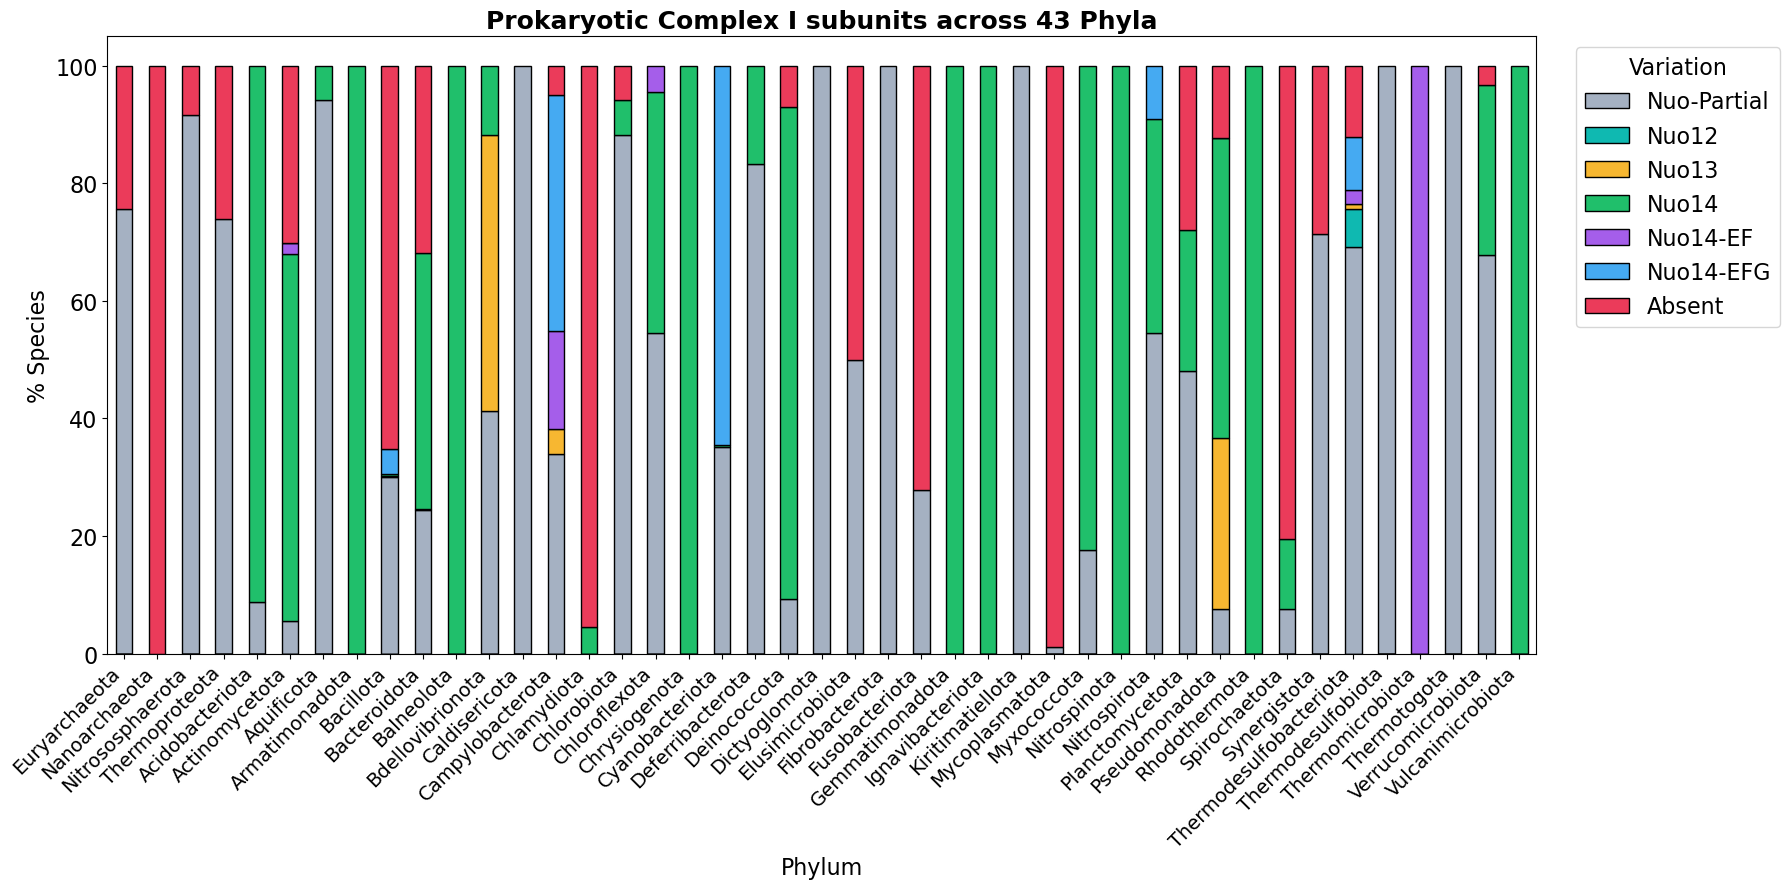

In [43]:
# Normalize the values to percentages (row-wise)
normalized_data = plot_data.set_index("Phylum")
normalized_data_percentage = normalized_data.div(normalized_data.sum(axis=1), axis=0) * 100

# Create the 100% stacked bar plot
plt.figure(figsize=(18, 9))
ax = normalized_data_percentage.plot(
    kind="bar",
    stacked=True,
    color=[complex_colors.get(variation, "#cccccc") for variation in normalized_data_percentage.columns],
    edgecolor="black",
    figsize=(18, 9)
)

# Add plot labels and legend
plt.title("Prokaryotic Complex I subunits across 43 Phyla", fontsize=18, weight='bold')
plt.ylabel("% Species", fontsize=16)
plt.xlabel("Phylum", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=16)

# Customize legend placement and appearance
plt.legend(
    title="Variation",
    bbox_to_anchor=(1.02, 1),
    loc="best",
    title_fontsize=16,
    fontsize=16
)

plt.tight_layout()
plt.show()

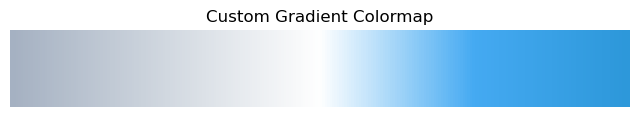

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom colors for the gradient
custom_colors = ["#a5b1c2", "#d1d8e0", '#ffff', "#45aaf2", "#2d98da"]  # Red → Yellow → Green → Blue → Purple

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)

# Display the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)
fig, ax = plt.subplots(figsize=(8, 1))
ax.imshow(gradient, aspect="auto", cmap=custom_cmap)
ax.set_axis_off()
plt.title("Custom Gradient Colormap")
plt.show()


Chi-Square Test Results:
Chi-Square Statistic: 1122.13
Degrees of Freedom: 12
P-Value: 1.004e-232


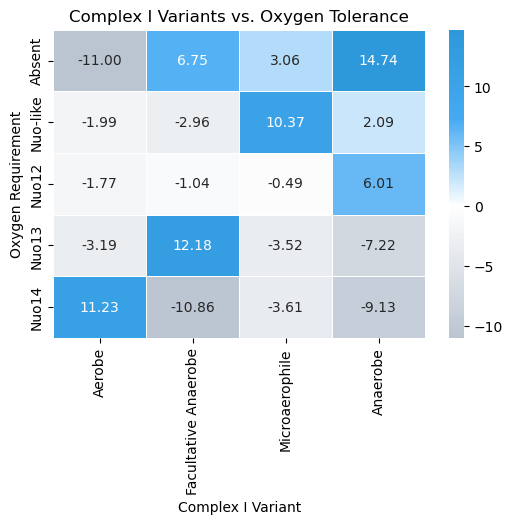

In [45]:
# Load the dataset
file_path = 'external_metadata/nuo_oxygen_wt_partial.csv'  # Update this path if necessary
data = pd.read_csv(file_path)

data = data[data['Oxygen Requirement']!='Facultative Aerobe']

# Creating a pivot table for Complex I variants vs. Oxygen Requirement
complex_variant_distribution = data.groupby(["Oxygen Requirement", "Variation"]).size().unstack().fillna(0)

# Performing Chi-Square test of independence for the entire variation dataset
chi2_variants, p_variants, dof_variants, expected_variants = stats.chi2_contingency(complex_variant_distribution)

# Calculating standardized residuals
observed_variants = complex_variant_distribution.to_numpy()
standardized_residuals_variants = (observed_variants - expected_variants) / (expected_variants ** 0.5)

# Converting residuals to a dataframe for visualization
residuals_variants_df = pd.DataFrame(standardized_residuals_variants, 
                                     index=complex_variant_distribution.index, 
                                     columns=complex_variant_distribution.columns)

# Displaying Chi-Square test results
print("Chi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2_variants:.2f}")
print(f"Degrees of Freedom: {dof_variants}")
print(f"P-Value: {p_variants:.3e}")

# Plotting heatmap of standardized residuals with annotations
plt.figure(figsize=(6, 4))
# Reset index to bring "Oxygen Requirement" into the columns
residuals_variants_df = residuals_variants_df.reset_index()

# Transpose the dataframe correctly
residuals_transposed = residuals_variants_df.set_index("Oxygen Requirement").T
residuals_transposed = residuals_transposed[['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']]
sns.heatmap(residuals_transposed, annot=True, cmap=custom_cmap, center=0, linewidths=0.5, fmt=".2f")

# Labels and title
plt.title("Complex I Variants vs. Oxygen Tolerance")
plt.xlabel("Complex I Variant")
plt.ylabel("Oxygen Requirement")

# Save figures
plt.savefig(output_dir / "oxygen_residuals_heatmaps.pdf", bbox_inches='tight', format='pdf', dpi=500)
plt.savefig(output_dir / "oxygen_residuals_heatmaps.png", bbox_inches='tight', dpi=500)
plt.show()


In [47]:
complex_variant_distribution.T

Oxygen Requirement,Aerobe,Anaerobe,Facultative Anaerobe,Microaerophile
Variation,,,,
Absent,481.0,312.0,387.0,84.0
Nuo-like,79.0,26.0,17.0,36.0
Nuo12,0.0,5.0,0.0,0.0
Nuo13,263.0,2.0,240.0,7.0
Nuo14,1590.0,78.0,196.0,57.0


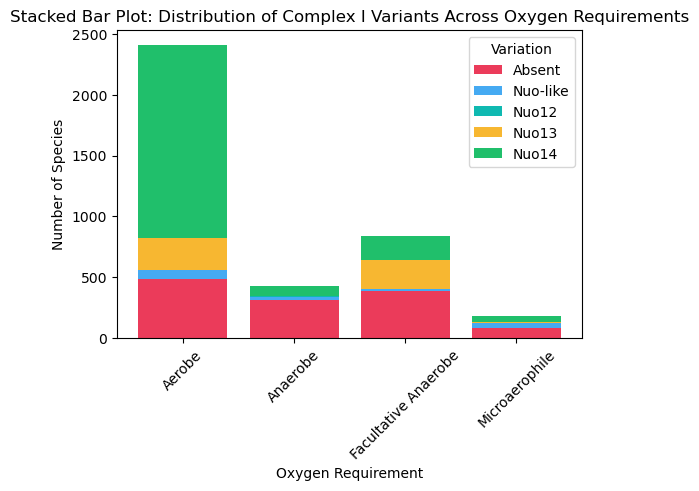

In [48]:
df = complex_variant_distribution.reset_index()

# Defining colors based on the provided color scheme
colors = ["#a5b1c2", "#f7b731", "#20bf6b", "#45aaf2", "#45aaf2", "#3867d6", "#a55eea", "#0fb9b1", '#4b6584', "#eb3b5a"]
labels = ['Nuo-Partial', 'Nuo13', 'Nuo14', 'Nuo-like', 'Nuo14-EFG', 'Nuo13-EFG', 'Nuo14-EF', 'Nuo12', 'Existing Annotation', 'Absent']

# Creating a color mapping for the variants in the dataset
complex_colors = dict(zip(labels, colors))

# Assign colors to existing variants in the dataset
variant_colors = [complex_colors.get(variant, "#808080") for variant in df.columns[1:]]  # Default to gray if not found

# Creating a stacked bar plot with custom colors
fig, ax = plt.subplots(figsize=(6, 4))

# Stacking bars
bottom_values = np.zeros(len(df["Oxygen Requirement"]))

# Plot each variation as a stacked bar with the assigned colors
for i, (variant, color) in enumerate(zip(df.columns[1:], variant_colors)):
    ax.bar(df["Oxygen Requirement"], df[variant], color=color, label=variant, bottom=bottom_values)
    bottom_values += df[variant]  # Update bottom for stacking

# Labels and title
ax.set_xlabel("Oxygen Requirement")
ax.set_ylabel("Number of Species")
ax.set_title("Stacked Bar Plot: Distribution of Complex I Variants Across Oxygen Requirements")
ax.legend(title="Variation", loc="upper right")

plt.xticks(rotation=45)
plt.savefig(output_dir / "oxygen_species.pdf", bbox_inches='tight', format='pdf', dpi=500)
plt.show()


## Analysis of Complex I Variants vs. Oxygen Requirement

Each cell’s numeric value indicates how many more (positive) or fewer (negative) species there are in that category than expected if there were no relationship.

---

### 1. Aerobes

- **Absent**: Very negative (−11.01)  
  - This means there are far **fewer** Aerobes that lack Complex I than expected.  
  - **Interpretation**: Aerobes nearly always have some Complex I variant.

- **Nuo14**: Strongly positive (+11.23)  
  - This means there are many more Aerobes with Nuo14 than expected.  
  - **Interpretation**: Aerobes are **strongly associated** with Nuo14.

Overall, Aerobes typically possess **Nuo14** and rarely fall under the “Absent” category.

---

### 2. Anaerobes

- **Absent**: Very positive (+14.73)  
  - Many more Anaerobes lack Complex I than expected.  

- **Nuo12**: Moderately positive (+6.03)  
  - More Anaerobes have Nuo12 than expected.

- **Nuo13** and **Nuo14**: Both strongly negative (−7.22, −9.13)  
  - Anaerobes rarely have these variants.

**Summary**: Anaerobes tend to **lack** Complex I entirely or, if they do have it, **Nuo12** is the favored variant.

---

### 3. Facultative Aerobes

- **All residuals near zero** (e.g., +0.19, +0.56, −0.13, −0.63, +0.01)  
  - No strong preference for any Complex I variant.  
  - **Interpretation**: Facultative Aerobes roughly match the expected counts under a scenario of no association.

Hence, Facultative Aerobes do not show a notable bias in Complex I usage.

---

### 4. Facultative Anaerobes

- **Absent**: Moderately positive (+6.74)  
  - More Facultative Anaerobes lack Complex I than expected.
  
- **Nuo13**: Very positive (+12.21)  
  - Far more Facultative Anaerobes have Nuo13 than expected.

- **Nuo14**: Very negative (−10.86)  
  - Facultative Anaerobes rarely have Nuo14.

Therefore, Facultative Anaerobes typically **lack** Complex I or rely on **Nuo13**, but almost never carry Nuo14.

---

### 5. Microaerophiles

- **Absent**: Slightly positive (+3.06)  
  - Slightly more Microaerophiles lack Complex I.  

- **Nuo‐like**: Strongly positive (+10.35)  
  - Many more Microaerophiles have the “Nuo‐like” variant than expected.

- **Nuo13** and **Nuo14**: Both mildly negative (about −3.5 each)  
  - Microaerophiles do not favor Nuo13 or Nuo14.

Thus, Microaerophiles tend to be **either absent** of Complex I or use a **“Nuo‐like”** variant.

---

## Key Observations

- **Aerobes**: Strongly associated with **Nuo14**, rarely “Absent”.  
- **Anaerobes**: Often **Absent** or **Nuo12**; rarely Nuo13/Nuo14.  
- **Facultative Aerobes**: No strong preference (near‐zero residuals).  
- **Facultative Anaerobes**: Commonly **Absent** or **Nuo13**, rarely Nuo14.  
- **Microaerophiles**: Often **Absent** or **Nuo‐like**; not typically Nuo13/Nuo14.

Overall, these patterns suggest that each organism’s oxygen requirement correlates with whether (and which) Complex I variant is present, likely reflecting different adaptations for oxygen handling and energy generation.


In [49]:
data['Variation'].value_counts()

Variation
Nuo14       1921
Absent      1264
Nuo13        512
Nuo-like     158
Nuo12          5
Name: count, dtype: int64

In [50]:
complex_variant_distribution.reset_index()['Oxygen Requirement'].values.tolist()

['Aerobe', 'Anaerobe', 'Facultative Anaerobe', 'Microaerophile']

In [51]:
['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']

['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']

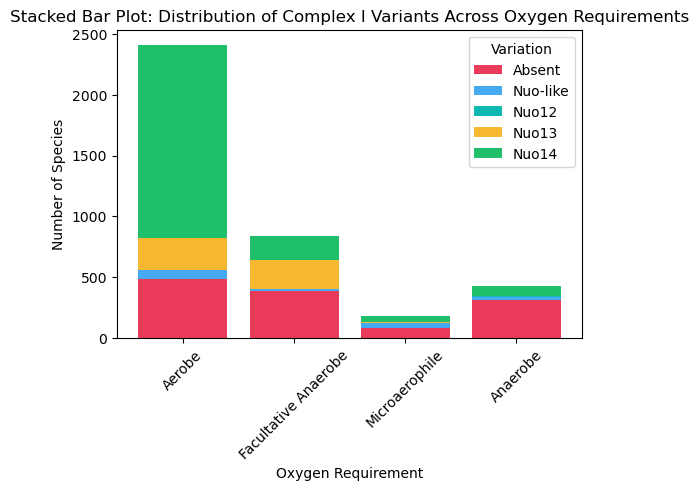

In [52]:
# Reorder the dataframe based on the desired order
desired_order = ['Aerobe', 'Facultative Anaerobe', 'Microaerophile', 'Anaerobe']
df = df.set_index("Oxygen Requirement").loc[desired_order].reset_index()

# Creating a stacked bar plot with custom colors and correct order
fig, ax = plt.subplots(figsize=(6, 4))

# Stacking bars
bottom_values = np.zeros(len(df["Oxygen Requirement"]))

# Plot each variation as a stacked bar with the assigned colors
for i, (variant, color) in enumerate(zip(df.columns[1:], variant_colors)):
    ax.bar(df["Oxygen Requirement"], df[variant], color=color, label=variant, bottom=bottom_values)
    bottom_values += df[variant]  # Update bottom for stacking

# Labels and title
ax.set_xlabel("Oxygen Requirement")
ax.set_ylabel("Number of Species")
ax.set_title("Stacked Bar Plot: Distribution of Complex I Variants Across Oxygen Requirements")
ax.legend(title="Variation", loc="upper right")

plt.xticks(rotation=45)
plt.savefig(output_dir / 'oxygen_species.pdf', bbox_inches='tight', format='pdf', dpi=500)
plt.show()


# Archaea Distribution

In [59]:
def plot_nuo_subunits_grid_(df, class_column, subunit_columns, subunits_order, subunits_colors, cols=3, label='archaea'):
    """
    Creates a grid of subplots for each class showing the distribution of Nuo subunits,
    following a specified order and color scheme, with individual x and y axes,
    and only absolute y-axis ticks (no floating values).

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    class_column (str): Column name for the class/grouping variable.
    subunit_columns (list): List of column names corresponding to Nuo subunits.
    subunits_order (list): Ordered list of subunit names for consistent plotting.
    subunits_colors (dict): Dictionary mapping subunit names to specific colors.
    cols (int): Number of columns in the grid layout (default: 3).
    """
    classes = df[class_column].unique()
    num_classes = len(classes)
    rows = math.ceil(num_classes / cols)  # Calculate number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows), sharex=False, sharey=False)
    axes = axes.flatten()  # Flatten in case of a 2D array

    for i, class_name in enumerate(classes):
        class_data = df[df[class_column] == class_name][subunit_columns].sum()
        no_species = df[(df['Class']==class_name)]['Species'].nunique()
        # phyla = df[(df['Class']==class_name)]['Phylum'].unique()[0]
        filtered_df = df[df['Class'] == class_name]
        if not filtered_df.empty:
            phyla = filtered_df['Phylum'].unique()[0]
        else:
            phyla = "Unknown"        
        
        # Ensure correct order and assign colors
        class_data = class_data.reindex(subunits_order)
        colors = [subunits_colors[subunit] for subunit in subunits_order]

        axes[i].bar(class_data.index, class_data.values, color=colors)
        axes[i].set_title(f"{phyla}: {class_name}\n(n={no_species})", fontsize=10)
        axes[i].set_ylabel("Number of Species")
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].set_xticks(range(len(subunits_order)))
        axes[i].set_xticklabels(subunits_order, rotation=90)

        # Set absolute y-axis ticks (no floating values)
        y_max = class_data.max()
        axes[i].set_yticks(range(0, int(y_max) + 1, max(1, int(y_max / 5))))

    # Hide empty subplots if classes < grid slots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(output_dir / f'{label}_dist_grid.pdf', bbox_inches='tight', format='pdf', dpi=500)
    plt.savefig(output_dir / f'{label}_dist_grid.png', bbox_inches='tight', dpi=500)
    plt.show()

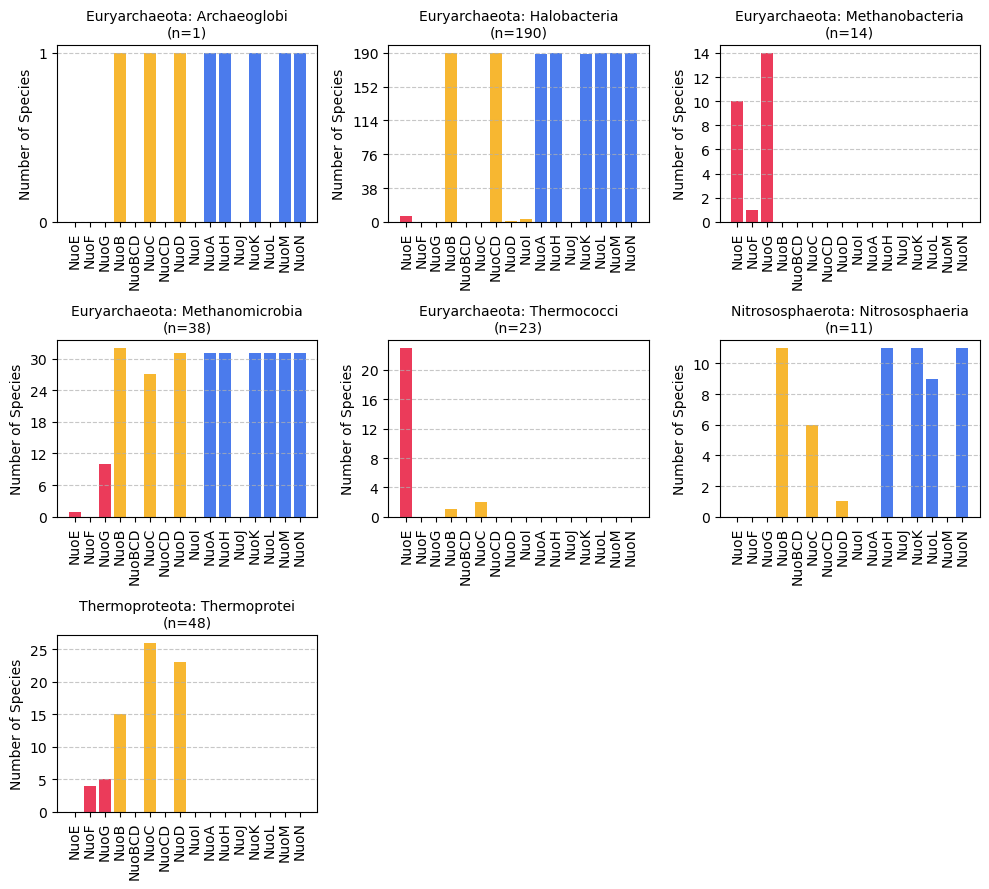

In [60]:
subunits_colors = {
    'NuoE': '#eb3b5a', 'NuoF': '#eb3b5a', 'NuoG': '#eb3b5a',
    'NuoB': '#f7b731', 'NuoBCD': '#f7b731', 'NuoC': '#f7b731',
    'NuoCD': '#f7b731', 'NuoD': '#f7b731', 'NuoI': '#f7b731',
    'NuoA': '#4b7bec', 'NuoH': '#4b7bec', 'NuoJ': '#4b7bec',
    'NuoK': '#4b7bec', 'NuoL': '#4b7bec', 'NuoM': '#4b7bec',
    'NuoN': '#4b7bec'
}

subunits_order = [
    'NuoE', 'NuoF', 'NuoG', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 
    'NuoD', 'NuoI', 'NuoA', 'NuoH', 'NuoJ', 'NuoK', 'NuoL', 
    'NuoM', 'NuoN'
]

archaea_data = nuo_bool_final[(nuo_bool_final['Organism']=='Archaea')]
archaea_data.sort_values(['Phylum', 'Class'], inplace=True)

selected_cols = ['Phylum', 'Class', 'Species', 'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN', 'Variation']
archaea_data_nr = archaea_data[selected_cols].drop_duplicates('Species')

plot_nuo_subunits_grid_(archaea_data_nr, 'Class', archaea_data_nr.columns[3:-1].tolist(), subunits_order, subunits_colors, cols=3)

In [61]:
# bacteria_data = nuo_bool_final[(nuo_bool_final['Organism']=='Bacteria')]
# bacteria_data.sort_values(['Phylum', 'Class'], inplace=True)

# selected_cols = ['Phylum', 'Class', 'Species', 'NuoA', 'NuoB', 'NuoBCD', 'NuoC', 'NuoCD', 'NuoD', 'NuoE', 'NuoF', 'NuoG', 'NuoH', 'NuoI', 'NuoJ', 'NuoK', 'NuoL', 'NuoM', 'NuoN', 'Variation']
# bacteria_data_nr = bacteria_data[selected_cols].drop_duplicates('Species')

# plot_nuo_subunits_grid_(bacteria_data_nr, 'Class', bacteria_data_nr.columns[3:-1].tolist(), subunits_order, subunits_colors, cols=3, label='bacteria')

## Archaea: Halobacterium salinarum

In [62]:
nuo_bool_final[(nuo_bool_final['Organism']=='Archaea')]['Phylum'].value_counts()

Phylum
Euryarchaeota       351
Thermoproteota       98
Nitrososphaerota     17
Name: count, dtype: int64

In [63]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Euryarchaeota')]['Class'].value_counts()

Class
Halobacteria       244
Methanomicrobia     62
Thermococci         26
Methanobacteria     18
Archaeoglobi         1
Name: count, dtype: int64

In [64]:
nuo_bool_final[(nuo_bool_final['Class']=='Methanomicrobia')]['Species'].value_counts()

Species
Methanosarcina mazei                    12
Methanosarcina barkeri                   5
Methanothrix sp.                         4
Methanosarcina siciliae                  3
uncultured Methanolobus sp.              3
Methanosarcina thermophila               2
Methanospirillum hungatei                2
Methanohalophilus mahii                  1
Methanosarcina flavescens                1
Methanosarcina sp. WH1                   1
Methanocella arvoryzae                   1
Methanospirillum sp. J.3.6.1-F.2.7.3     1
Methanosarcina sp. WWM596                1
Methanosarcina sp. MTP4                  1
Methanococcoides methylutens             1
Methanolobus sediminis                   1
Methanolobus mangrovi                    1
Methanococcoides orientis                1
Methanofollis formosanus                 1
Methanolobus zinderi                     1
Methanohalophilus portucalensis          1
Methanohalophilus halophilus             1
Methanosarcina horonobensis              1
Met

In [65]:
nuo_bool_final[(nuo_bool_final['Species']=='Halorhabdus utahensis')].iloc[:, 7:-1].sum()

NuoA      1
NuoB      1
NuoBCD    0
NuoC      0
NuoCD     1
NuoD      0
NuoE      1
NuoF      0
NuoG      0
NuoH      1
NuoI      0
NuoJ      0
NuoK      1
NuoL      1
NuoM      1
NuoN      1
dtype: int64

In [66]:
nuo_bool_final[(nuo_bool_final['Species']=='Halorhabdus utahensis')].head()

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
19674,Euryarchaeota,Halobacteria,Halorhabdus utahensis,CP001687.1,GCA_000023945.1_ASM2394v1_genomic.fna,Chromosome,Archaea,True,True,False,...,False,False,True,False,False,True,True,True,True,Nuo-Partial


In [67]:
accession = 'CP006884.1'

In [68]:
nuo_bool_final[(nuo_bool_final['Accession']==accession)].iloc[:, 7:]

,NuoA,NuoB,NuoBCD,NuoC,NuoCD,NuoD,NuoE,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
17966,True,True,False,False,True,False,False,False,False,True,False,False,True,True,True,True,Nuo-Partial


In [69]:
nuohmmer_unfiltered[(nuohmmer_unfiltered['Accession']==accession) & (nuohmmer_unfiltered['Subunit']=='NuoI')]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
417889,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_858,2.600000e-07,29.2,7.7,# 811491 # 811820 # 1 # ID=1_858;partial=00;st...,NuoI,85,FinedTuned2,811491,811820,-6.585027,109,1,2
417891,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_1814,4.100000e-07,28.5,24.8,# 1762929 # 1763759 # -1 # ID=1_1814;partial=0...,NuoI,85,FinedTuned2,1762929,1763759,-6.387216,276,-1,4
417893,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_1921,3.300000e-07,28.8,24.1,# 1868583 # 1870718 # -1 # ID=1_1921;partial=0...,NuoI,85,FinedTuned2,1868583,1870718,-6.481486,711,-1,5
417899,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2031,2.500000e-35,120.5,4.4,# 1978006 # 1978467 # 1 # ID=1_2031;partial=00...,NuoI,85,FinedTuned2,1978006,1978467,-34.602060,153,1,7


In [70]:
nuohmmer_unfiltered[(nuohmmer_unfiltered['Accession']==accession) & (nuohmmer_unfiltered['Subunit']=='NuoJ')]

,Accession,Replicon,GenomeFile,SequenceLength(Mb),ProteomeFile,ProteinAccession,evalue,BitScore,Bias,SequenceDesc,Subunit,SeqsClustThreshold,HMMParameter,Start,End,log10evalue,EstProtLength,Strand,Cluster
417900,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2032,6.800000e-21,72.9,11.9,# 1978761 # 1979030 # 1 # ID=1_2032;partial=00...,NuoJ,85,FinedTuned2,1978761,1979030,-20.167491,89,1,8
417901,CP006884.1,Chromosome,GCA_000504565.2_ASM50456v2_genomic.fna,3.006708,GCA_000504565.2_ASM50456v2_cds_proteins.faa,CP006884.1_2033,1.800000e-09,35.5,0.1,# 1979027 # 1979425 # 1 # ID=1_2033;partial=00...,NuoJ,85,FinedTuned2,1979027,1979425,-8.744727,132,1,8


In [71]:
nuo_bool_final[nuo_bool_final['Species']=='Rhodobacter sphaeroides']

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation


In [72]:
taxonomy[taxonomy['Species']=='Rhodobacter sphaeroides']

,TaxID,Organism,Lineage,LineageTaxIDs,Superkingdom,Phylum,Class,Order,Family,Genus,Species,Strain


In [73]:
archaea_data['Species'].nunique()

325

In [74]:
taxonomy[taxonomy['Organism']=='Archaea']['Lineage'].nunique()

441

In [75]:
genomes_dataset[genomes_dataset['Organism']=='Archaea']['Species'].nunique()

431

In [76]:
interested_species = []
for species in taxonomy['Species'].unique():
    if "Pyrococcus".lower() in species.lower():
        print(species)
        interested_species.append(species)

Pyrococcus abyssi
Pyrococcus horikoshii
Pyrococcus furiosus
Pyrococcus yayanosii
Pyrococcus sp. NA2
Pyrococcus kukulkanii
Pyrococcus sp. ST04


In [77]:
nuo_bool_final[nuo_bool_final['Species'].isin(interested_species)].head()

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation


In [78]:
phylum_variation_summary['%Species'] = (phylum_variation_summary['TotalSpecies']/11039)*100

In [79]:
phylum_variation_summary.sort_values('%Species', ascending=False).head(10)

,Phylum,TotalSpecies,SearchedSpecies,Nuo-Partial,Nuo12,Nuo13,Nuo14,Nuo14-EF,Nuo14-EFG,Absent,%Species
32,Pseudomonadota,4617,4052,347,0,1343,2362,2,0,565,41.824441
1,Actinomycetota,2144,1499,120,0,0,1339,39,1,645,19.422049
4,Bacillota,1690,588,508,0,1,7,0,72,1102,15.309358
5,Bacteroidota,862,588,211,0,1,376,0,0,274,7.808678
19,Euryarchaeota,352,266,266,0,0,0,0,0,86,3.188695
14,Cyanobacteriota,262,262,92,0,0,1,0,169,0,2.373403
25,Mycoplasmatota,186,2,2,0,0,0,0,0,184,1.684935
9,Campylobacterota,161,153,55,0,7,0,27,65,8,1.458465
36,Thermodesulfobacteriota,123,108,85,8,1,0,3,11,15,1.114231
34,Spirochaetota,118,23,9,0,0,14,0,0,95,1.068937


In [80]:
genomes_dataset[genomes_dataset['Organism']=='Bacteria']['Species'].nunique()

10608

In [81]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Species'].nunique()

108

In [82]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Species'].value_counts()

Species
Geobacter sulfurreducens              8
uncultured Pseudodesulfovibrio sp.    4
uncultured Desulfuromusa sp.          2
Syntrophotalea acetylenica            2
Geomonas nitrogeniifigens             2
                                     ..
Megalodesulfovibrio gigas             1
Maridesulfovibrio hydrothermalis      1
Desulfuromonas sp. DDH964             1
Thermodesulfobacterium sp. TA1        1
Desulfobulbus oralis                  1
Name: count, Length: 108, dtype: int64

In [83]:
nuo_bool_final[nuo_bool_final['Phylum']=='Thermodesulfobacteriota']['Variation'].value_counts()

Variation
Nuo-Partial    103
Nuo14-EFG       13
Nuo12           10
Nuo14-EF         4
Nuo13            1
Name: count, dtype: int64

In [84]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]['Class'].unique()

array(['Desulfuromonadia', 'Desulfobacteria', 'Desulfarculia'],
      dtype=object)

In [85]:
species_list = nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]['Species'].unique()

In [86]:
for species in species_list:
    print(species)

Syntrophotalea carbinolica
Desulfonema limicola
Desulfococcus multivorans
Syntrophotalea acetylenica
Desulfosarcina alkanivorans
Syntrophotalea acetylenivorans
Desulfoferula mesophila
uncultured Desulfobacter sp.


In [87]:
nuo_bool_final[(nuo_bool_final['Phylum']=='Thermodesulfobacteriota') & (nuo_bool_final['Variation']=='Nuo12')]

,Phylum,Class,Species,Accession,GenomeFile,Replicon,Organism,NuoA,NuoB,NuoBCD,...,NuoF,NuoG,NuoH,NuoI,NuoJ,NuoK,NuoL,NuoM,NuoN,Variation
16640,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea carbinolica,CP000142.2,GCA_000012885.1_ASM1288v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
19119,Thermodesulfobacteriota,Desulfobacteria,Desulfonema limicola,CP061799.1,GCA_017377355.1_ASM1737735v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
22366,Thermodesulfobacteriota,Desulfobacteria,Desulfococcus multivorans,NZ_CP015381.1,GCF_001854245.1_ASM185424v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
22367,Thermodesulfobacteriota,Desulfobacteria,Desulfococcus multivorans,NZ_CP019913.2,GCF_002009335.2_ASM200933v2_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
24109,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenica,NZ_CP015518.1,GCF_001887715.1_ASM188771v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
24110,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenica,NZ_CP015455.1,GCF_001888165.1_ASM188816v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
25335,Thermodesulfobacteriota,Desulfobacteria,Desulfosarcina alkanivorans,NZ_AP021874.1,GCF_009688945.1_ASM968894v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
25843,Thermodesulfobacteriota,Desulfuromonadia,Syntrophotalea acetylenivorans,NZ_CP015519.1,GCF_001887775.1_ASM188777v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
27064,Thermodesulfobacteriota,Desulfarculia,Desulfoferula mesophila,NZ_AP028679.1,GCF_037076455.1_ASM3707645v1_genomic.fna,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
29028,Thermodesulfobacteriota,Desulfobacteria,uncultured Desulfobacter sp.,OY762229.1,GCA_963665355.1_piMetSpee1.Desulfobacter_sp_1....,Chromosome,Bacteria,True,False,True,...,True,True,True,True,True,True,True,True,True,Nuo12
